In [1]:
import pandas as pd
import numpy as np
import math

# For making plots and figures
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning library
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster

import time, random

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

from sklearn.preprocessing import MinMaxScaler

import ClusterEnsembles as CE
from sklearn.metrics import normalized_mutual_info_score

from sklearn.neighbors import NearestCentroid
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist

import time

In [2]:
# Set path for loading dataset from your local computer
dataset_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES Data/Project 3 IR+Raman Data/'
# Set path for saving results to your local computer
output_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES ML results/Project 3 IR+Raman Results/'

### All Functions

#### Function "load_dataset"
* Define a function to load the IR or Raman data set
* Read in the dataset from: 
* "dataset_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES Data/Project 3 IR+Raman Data/'"
* You must change it to your own path!!

In [3]:
def load_dataset(filename):
    df = pd.read_csv(dataset_path+filename+".csv")
    # Save the number of datapoints in m variable
    m = df.shape[0]
    print(m)
    
    # Return modified DataFrame and m
    return df, m

#### Function "get_X_similarity_matrix"
* Function to transform original DataFrame of IR or Raman Spectrum into an n by n similarity matrix
* Can use each of the correlation coefficient

In [4]:
corr_methods = ['pearson','spearman']

def get_X_correlation_matrix(df,i0,corr_method):
    # Subset dataframe by keep only the fitted spectra
    df_tmp = df.iloc[:,i0:]
    # Compute pairwise correlation of rows
    X_matrix = df_tmp.T.corr(method=corr_method)
    print(X_matrix.shape)
    return X_matrix

#### Function "Distortion"
* Function to calculate the Distortion of a clustering solution 
* This is what we will use to calculate the "weight" in the weighted combining strategy later

In [5]:
def Distortion(X, label):
    # Given X and Y, use NearestCentroid() to find centroids of clusters
    clf = NearestCentroid()
    clf.fit(X,label)
    # find cluster centers 
    closest, _ = pairwise_distances_argmin_min(clf.centroids_,X)
    cluster_centers = X.loc[closest]

    return sum(np.min(cdist(X, cluster_centers,'euclidean'), axis=1))/X.shape[0]

#### Function "get_KMeans_BCs"
Generate base clustering library using K-Means algorithm
* For each representation of Dataset, repeat 50 iterations, each iteration randomly sample the requested number of clusters from the range of 2 to max_k. 
* max_k is set to be square root of number of datapoints.
* This will generate a total of 150 base clustering (3 dataset representation * 50 iterations)

In [6]:
def get_KMeans_BCs():
    # Create a dataframe for collecting predicted cluster labels after each run
    df_result = pd.DataFrame()
    # Create another dataframe for collecting BC internal quality validation scores
    df_BC_internal_quality = pd.DataFrame(columns=["BC_run","NMI_Y","Distor","Silhouette","Calinski_Harabasz","Davies_Bauldin"])
    
    ## idx for keep track of base clustering outcomes generated in each run
    ## dataset_idx for keep track of dataset represetation used 
    idx, dataset_idx = 0,0
    for X_data in X_datas:
        print(dataset_idx+1, "dataset representation")
        dataset_idx += 1
        num = 50
        for n_ite in range(num):
            print("total iteration ", idx+1)
            row= []
            # set k, the number of clusters for each clustering run, by randomly drawing a number between 2 to max_k
            k = random.randint(2,max_k)
            print("n_clusters set to ", k)
              
            # Generate K-Means base clustering outcome using a randomly sampled number of cluster K
            k_means = KMeans(n_clusters=k)
            BC_label = k_means.fit_predict(X_data)
            # Save Base Clustering Outcome into df_result DataFrame
            predicted_label = { "Kmeans_"+str(idx):BC_label}
            predicted_label = pd.DataFrame(predicted_label)
            df_result = pd.concat([df_result,pd.DataFrame(predicted_label)],axis=1)
            
            # Calculate internal quality validation scores, and save into df_BC_internal_quality DataFrame
            row.append("Kmeans_"+str(idx))
            row.append(normalized_mutual_info_score(Y,BC_label))
            row.append(Distortion(X_datas[0], BC_label))
            row.append(silhouette_score(X_datas[0],BC_label))
            row.append(calinski_harabasz_score(X_datas[0],BC_label))
            row.append(davies_bouldin_score(X_datas[0],BC_label))
            df_BC_internal_quality.loc[idx,:] = row
                    
            idx += 1
    df_result = df_result.T
    print("A total of ", idx, "iterations of clustering completed")
    return df_result, df_BC_internal_quality

#### Function "get_Hier_BCs"
Generate base clustering library using Hierarchical clustering algorithm
* For each representation of Dataset and each linkage method, repeat 10 iterations, each iteration randomly sample the requested number of clusters from the range of 2 to max_k. 
* max_k is set to be square root of number of datapoints.
* This will generate a total of 150 base clustering (3 data representations * 5 linkage methods * 10 iterations)

In [7]:
methods = ['single', 'complete','average','weighted','ward']
def get_Hier_BCs():
    # Create a dataframe for collecting predicted cluster labels after each run
    df_result = pd.DataFrame()
    # Create another dataframe for collecting BC internal quality validation indexes
    df_BC_internal_quality = pd.DataFrame(columns=["BC_run","NMI_Y","Distor","Silhouette","Calinski_Harabasz","Davies_Bauldin"])
    
    idx, dataset_idx = 0,0
    for X_data in X_datas:
        print(dataset_idx+1, "dataset representation")
        dataset_idx += 1
        for method in methods:
            print(method)
            k_select = np.random.choice(range(2,max_k),10,replace=False)
            num = 10
            for n_ite in range(num):
                row = []
                print("total iteration ", idx+1)
                # set k, the number of clusters for each clustering run, by randomly drawing a number between 2 to max_k
                k=k_select[n_ite]
                print("n_clusters set to ", k)
                Z = linkage(X_data, method=method)
                BC_label = fcluster(Z, t=k, criterion='maxclust')
                    
                row.append("Hier_"+str(idx))
                row.append(normalized_mutual_info_score(Y,BC_label))
                row.append(Distortion(X_datas[0], BC_label))
                row.append(silhouette_score(X_datas[0],BC_label))
                row.append(calinski_harabasz_score(X_datas[0],BC_label))
                row.append(davies_bouldin_score(X_datas[0],BC_label))
                df_BC_internal_quality.loc[idx,:] = row
            
                predicted_label = { "Hier_"+str(idx):BC_label}
                df_result = pd.concat([df_result,pd.DataFrame(predicted_label)],axis=1)
                                        
                idx += 1
    df_result = df_result.T
    print("A total of ", idx, "iterations of clustering completed")
    return df_result, df_BC_internal_quality           

## I. Start running this script from here
### Process one dataset at a time
#### Step 1. Load IR or Raman data set and calculate correlation coefficient matrix

* You have to change the filename to the dataset that you are generating ensemble library for.
* The dimension of the dataset will determine the maximum of clusters that we will be requesting when generate ensemble library

In [90]:
filename = "0.971 scaled DFT 6-311++G(d,p) IR dataset"
df, m = load_dataset(filename)
df.head(1)

# Display first data point (row)
print("number of datapoints = ", m)
max_k = int(math.sqrt(m))
print("Max number of clusters",max_k)

# Y is the ground truth class label
Y=df.Class

930
number of datapoints =  930
Max number of clusters 30


#### Preprocess data set
* Use fitted IR or Raman spectra as features (n = 1801 for IR or 801 for Raman)
* Or use a correlation coefficient function to generate pairwise spectral similarity matrix
* Create a collection of datasets represented by either the fitted spectrum as feature or transformed into pairwise spectral similarity matrics
* Should generate a total of three versions of the data representations

In [91]:
X_datas = []
X_datas.append(df.iloc[:,2:])

for corr_method in corr_methods:
    print(corr_method)
    X_data = get_X_correlation_matrix(df,2,corr_method)
    X_datas.append(X_data)
print(len(X_datas))

pearson
(930, 930)
spearman
(930, 930)
3


### Generate 150 ensemble members using each clustering algorithm for a total of 300 ensemble members for the full ensemble library

#### Clustering algorithms used
* sklearn.cluster.Kmeans
* scipy.cluster.hierarchy.fcluster

#### Qualities calculated
* NMI_Y: 
* Distortion (Distor): the average of the squared distances from the cluster centers of the respective clusters. Euclidean distance metric is used.

#### Internal quality indices calculated 
* silhouette_score
* calinski_harabasz_score
* davies_bouldin_score


In [99]:
run_i = "run_17"

Kmeans_result, Kmeans_BC_quality = get_KMeans_BCs()

Hier_result, Hier_BC_quality = get_Hier_BCs()

1 dataset representation
total iteration  1
n_clusters set to  3
total iteration  2
n_clusters set to  26
total iteration  3
n_clusters set to  29
total iteration  4
n_clusters set to  10
total iteration  5
n_clusters set to  16
total iteration  6
n_clusters set to  16
total iteration  7
n_clusters set to  30
total iteration  8
n_clusters set to  29
total iteration  9
n_clusters set to  20
total iteration  10
n_clusters set to  9
total iteration  11
n_clusters set to  23
total iteration  12
n_clusters set to  25
total iteration  13
n_clusters set to  11
total iteration  14
n_clusters set to  18
total iteration  15
n_clusters set to  20
total iteration  16
n_clusters set to  28
total iteration  17
n_clusters set to  28
total iteration  18
n_clusters set to  25
total iteration  19
n_clusters set to  5
total iteration  20
n_clusters set to  17
total iteration  21
n_clusters set to  2
total iteration  22
n_clusters set to  8
total iteration  23
n_clusters set to  27
total iteration  24
n_c

total iteration  43
n_clusters set to  5
total iteration  44
n_clusters set to  3
total iteration  45
n_clusters set to  12
total iteration  46
n_clusters set to  21
total iteration  47
n_clusters set to  4
total iteration  48
n_clusters set to  15
total iteration  49
n_clusters set to  27
total iteration  50
n_clusters set to  6
2 dataset representation
single
total iteration  51
n_clusters set to  26
total iteration  52
n_clusters set to  4
total iteration  53
n_clusters set to  10
total iteration  54
n_clusters set to  17
total iteration  55
n_clusters set to  19
total iteration  56
n_clusters set to  28
total iteration  57
n_clusters set to  29
total iteration  58
n_clusters set to  11
total iteration  59
n_clusters set to  8
total iteration  60
n_clusters set to  3
complete
total iteration  61
n_clusters set to  21
total iteration  62
n_clusters set to  20
total iteration  63
n_clusters set to  25
total iteration  64
n_clusters set to  2
total iteration  65
n_clusters set to  18
t

#### Merge all BC generated using two different clustering algorithms together
* Two DataFrame are created. 
* One is to store the clustering outcome (a class label predicted for each datapoint)
* One is to store the internal validation score calculated for each BC

In [100]:
df_result_merge = pd.concat([Kmeans_result,Hier_result],axis=0)

df_BC_quality_merge = pd.concat([Kmeans_BC_quality,Hier_BC_quality],axis=0)

df_result_merge.to_csv(output_path+filename+" BC library "+run_i+".csv")
df_BC_quality_merge.to_csv(output_path+filename+" BC library quality indices "+run_i+".csv",index=False)

* The average NMI of all ensemble members against ground truth

In [101]:
NMI_Y_average = df_BC_quality_merge["NMI_Y"].mean()
print(NMI_Y_average)

0.5271963754267561


## II. Calculate additional quality indices
1. Obtaining consensus clustering solution by applying a consensus function
    * CSPA
    * HBGF
2. Calculate NMI for each clustering solution vs. the full ensemble consensus solution

#### Step 1. Obtaining consensus clustering solution using the full ensemble library
Use ClusterEnsemble Library

The Input as Numpy Array

In [15]:
def get_Consensus_solution(ensemble, consensus_function):
    Input = ensemble.values
    consensus_solution = CE.cluster_ensembles(Input, solver = consensus_function, verbose=True, nclass = 16, random_state=42)
    NMI_EN =  normalized_mutual_info_score(Y,consensus_solution)
    return consensus_solution, NMI_EN

* Generate the full ensemble concensus solution, which will be an array of cluster labels for all datapoints.
* Add it as a new row to the df_result_merge DataFrame for later analysis
*_There are 300 ensemble members, so first subset the df_result_merge for the first 300 rows, then use df.values to change this DataFrame to Numpy Array_*

In [102]:
df_result_merge.loc['CSPA_EN'], Y_CSPA_EN = get_Consensus_solution(df_result_merge.iloc[0:300], 'cspa')
print("NMI of the consensus solution created using CSPA function is:", Y_CSPA_EN)

df_result_merge.loc['HBGF_EN'], Y_HBGF_EN = get_Consensus_solution(df_result_merge.iloc[0:300], 'hbgf')
print("NMI of the consensus solution created using HBGF function is:", Y_HBGF_EN)

Cluster Ensembles
    - Number of classes: 16
    - Solver: cspa
    - Length of labels: 930
    - Number of labels: 300
NMI of the consensus solution created using CSPA function is: 0.6439261721269309
Cluster Ensembles
    - Number of classes: 16
    - Solver: hbgf
    - Length of labels: 930
    - Number of labels: 300
NMI of the consensus solution created using HBGF function is: 0.6595916909806736


In [103]:
df_result_merge.to_csv(output_path+filename+" BC library "+run_i+".csv")

#### Step 2. Another quality index as introduced in Lin_Fern (2008) Paper
SNMI(C,E) = Sum(NMI(C, Ci))
Given a library of BC solutions to select from, SNMI is used to measure the quality of each clustering solution Ci. 

This measures how well a particular clustering agrees with the general trend contained in ensemble library E.

In [18]:
def SNMI(df):
    SNMI = []
    for row in range(300):
        print("BC member",row+1)
        a = df.iloc[row]
        #print(a)
        SNMI_score = 0
        for j in range(300):
            b = df.iloc[j]
            NMI_score = normalized_mutual_info_score(a,b)
            SNMI_score += NMI_score
        print(SNMI_score/300)
        SNMI.append(SNMI_score/300)
    return SNMI

In [104]:
start = time.time()
df_BC_quality_merge["SNMI"]=SNMI(df_result_merge)
end = time.time()
print("Time elapsed = ", end-start)

BC member 1
0.3836160545470377
BC member 2
0.6022998337775356
BC member 3
0.6020455863614605
BC member 4
0.5543296510635023
BC member 5
0.5764121366988051
BC member 6
0.5806645929804761
BC member 7
0.5885654255371396
BC member 8
0.5917542709978205
BC member 9
0.5846384939700754
BC member 10
0.5437328605074636
BC member 11
0.5965661012388506
BC member 12
0.5941934770367533
BC member 13
0.5582878304283
BC member 14
0.581426784279816
BC member 15
0.5898868821153932
BC member 16
0.597126645991526
BC member 17
0.6023934655308694
BC member 18
0.5996196430875418
BC member 19
0.4674610911033823
BC member 20
0.5836417737757389
BC member 21
0.30292074286409887
BC member 22
0.5387413860112313
BC member 23
0.5826843898813098
BC member 24
0.5558425694046124
BC member 25
0.572092360770217
BC member 26
0.5770375302943733
BC member 27
0.5945772677598871
BC member 28
0.5397732820207992
BC member 29
0.5729478007909746
BC member 30
0.5873804075816442
BC member 31
0.5897701267645131
BC member 32
0.5821416

0.28840638360633203
BC member 253
0.017936725625634097
BC member 254
0.3644199030831827
BC member 255
0.2730837115547705
BC member 256
0.27814991270428063
BC member 257
0.3105065401891334
BC member 258
0.317968175063413
BC member 259
0.3168528511494824
BC member 260
0.286749609994418
BC member 261
0.5389697613461015
BC member 262
0.33886923804206737
BC member 263
0.5533230955347826
BC member 264
0.5401908015548045
BC member 265
0.3966374652985942
BC member 266
0.5378955819952822
BC member 267
0.36531181586820355
BC member 268
0.40222652454548435
BC member 269
0.5370775234453237
BC member 270
0.4032198917774609
BC member 271
0.5418261566046239
BC member 272
0.5360150999000197
BC member 273
0.38778515529358193
BC member 274
0.34394776566383645
BC member 275
0.5509664213402977
BC member 276
0.5345057819901683
BC member 277
0.5515470394402897
BC member 278
0.5470566911875165
BC member 279
0.2947411070609128
BC member 280
0.270596989478703
BC member 281
0.2721685969640904
BC member 282
0.04

##### Save Quality DataFrame

In [105]:
df_BC_quality_merge.to_csv(output_path+filename+" BC library quality indices "+run_i+".csv",index=False)

## III. Take a look at all five quality index distribution

#### Produce Averaged Plot

The central problem that this project is trying to answer is, without knowing the ground-truth, how to optimize the unsupervised clustering analysis?

In [4]:
def get_final_average(n):

    Average_NMI_Y = 0
    runs = []
    for i in range(n):
        print("run_"+str(i+1))

        run_i = pd.read_csv(output_path+filename+" BC library quality indices run_"+str(i+1)+".csv",index_col="BC_run")
        Average_NMI_Y += run_i['NMI_Y'].mean()
        #print(Average_NMI_Y)
        runs.append(run_i)
    
    print("Total of ", len(runs), "iterations to avearge")
    df_concat=pd.concat(runs)
    unique_index = df_concat.index.unique()
    
    average = []
    for index in unique_index:
        average.append(df_concat.loc[index].mean())
        
    df_final_average = pd.DataFrame(average,index=unique_index)
    
    return df_final_average, Average_NMI_Y/n

run_1
run_2
run_3
run_4
run_5
run_6
run_7
run_8
run_9
run_10
run_11
run_12
run_13
run_14
run_15
run_16
run_17
run_18
run_19
run_20
Total of  20 iterations to avearge
0.5262603021820722


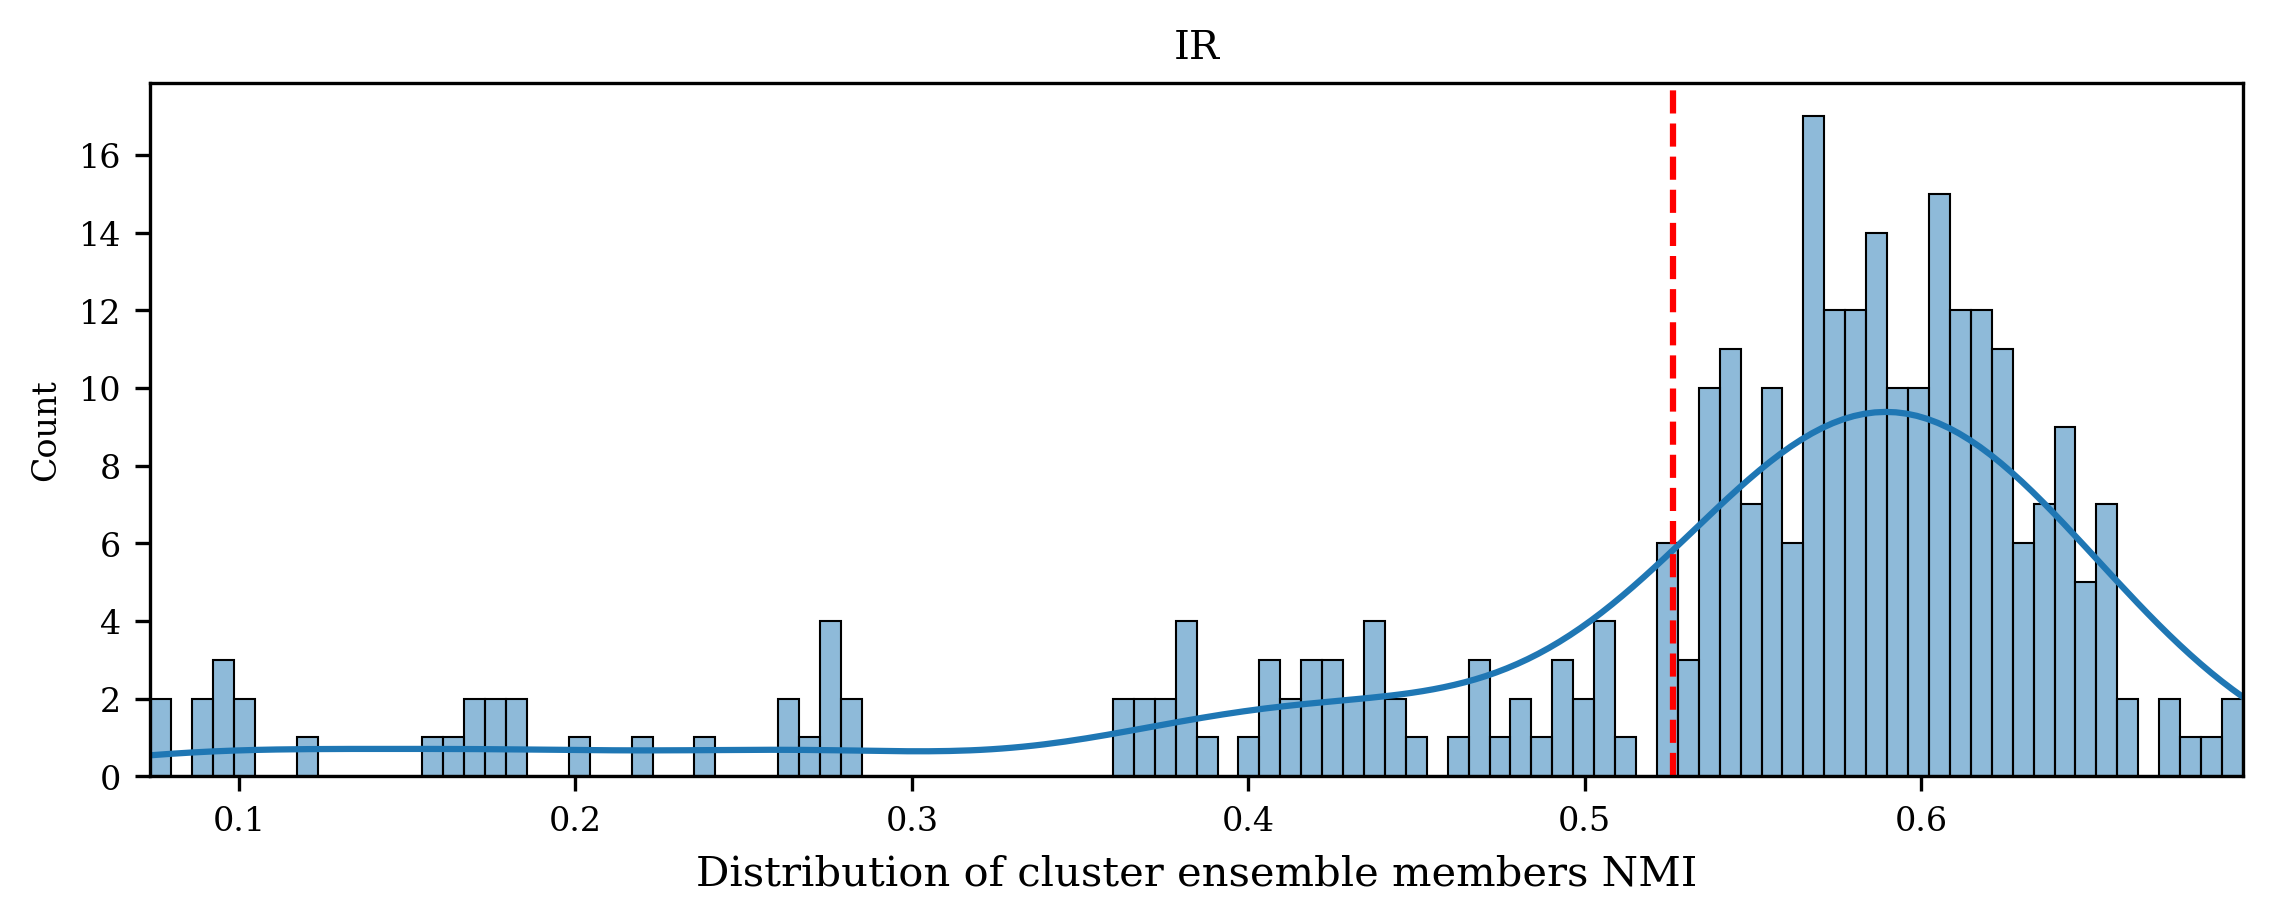

In [15]:
filename="0.971 scaled DFT 6-311++G(d,p) IR dataset"
df_final_average, NMI_Average = get_final_average(20)
print(NMI_Average)
df_final_average.to_csv(output_path+filename+" BC library quality indices compiled.csv",index=False)

fig = plt.figure(figsize=(9,3), dpi=300)
plt.rc('font', family='serif', size = 8)
plt.title("IR")
plt.xlabel('Distribution of cluster ensemble members NMI',fontsize=10)
plt.xlim(df_final_average["NMI_Y"].min(),df_final_average["NMI_Y"].max())
sns.histplot(df_final_average["NMI_Y"],color="#1f77b4", kde=True,bins=100)
plt.axvline(x=NMI_Average, color="r", linestyle="--")
plt.show()
fig.savefig(output_path+filename+" Distribution of cluster ensemble members NMI.png", bbox_inches="tight", dpi = 300)

In [16]:
print("75th percentile of NMI distribution:", np.percentile(df_final_average["NMI_Y"], 75))

75th percentile of NMI distribution: 0.6095036968729952


* Normalize the quality indices values using min_max nomalization
Here is an tutorial that I followed:
https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79

In [9]:
df_tmp = df_final_average.copy()

# build the scaler model
scaler = MinMaxScaler()

scaler.fit(df_tmp.iloc[:,2:])

X_scaled = scaler.transform(df_tmp.iloc[:,2:])

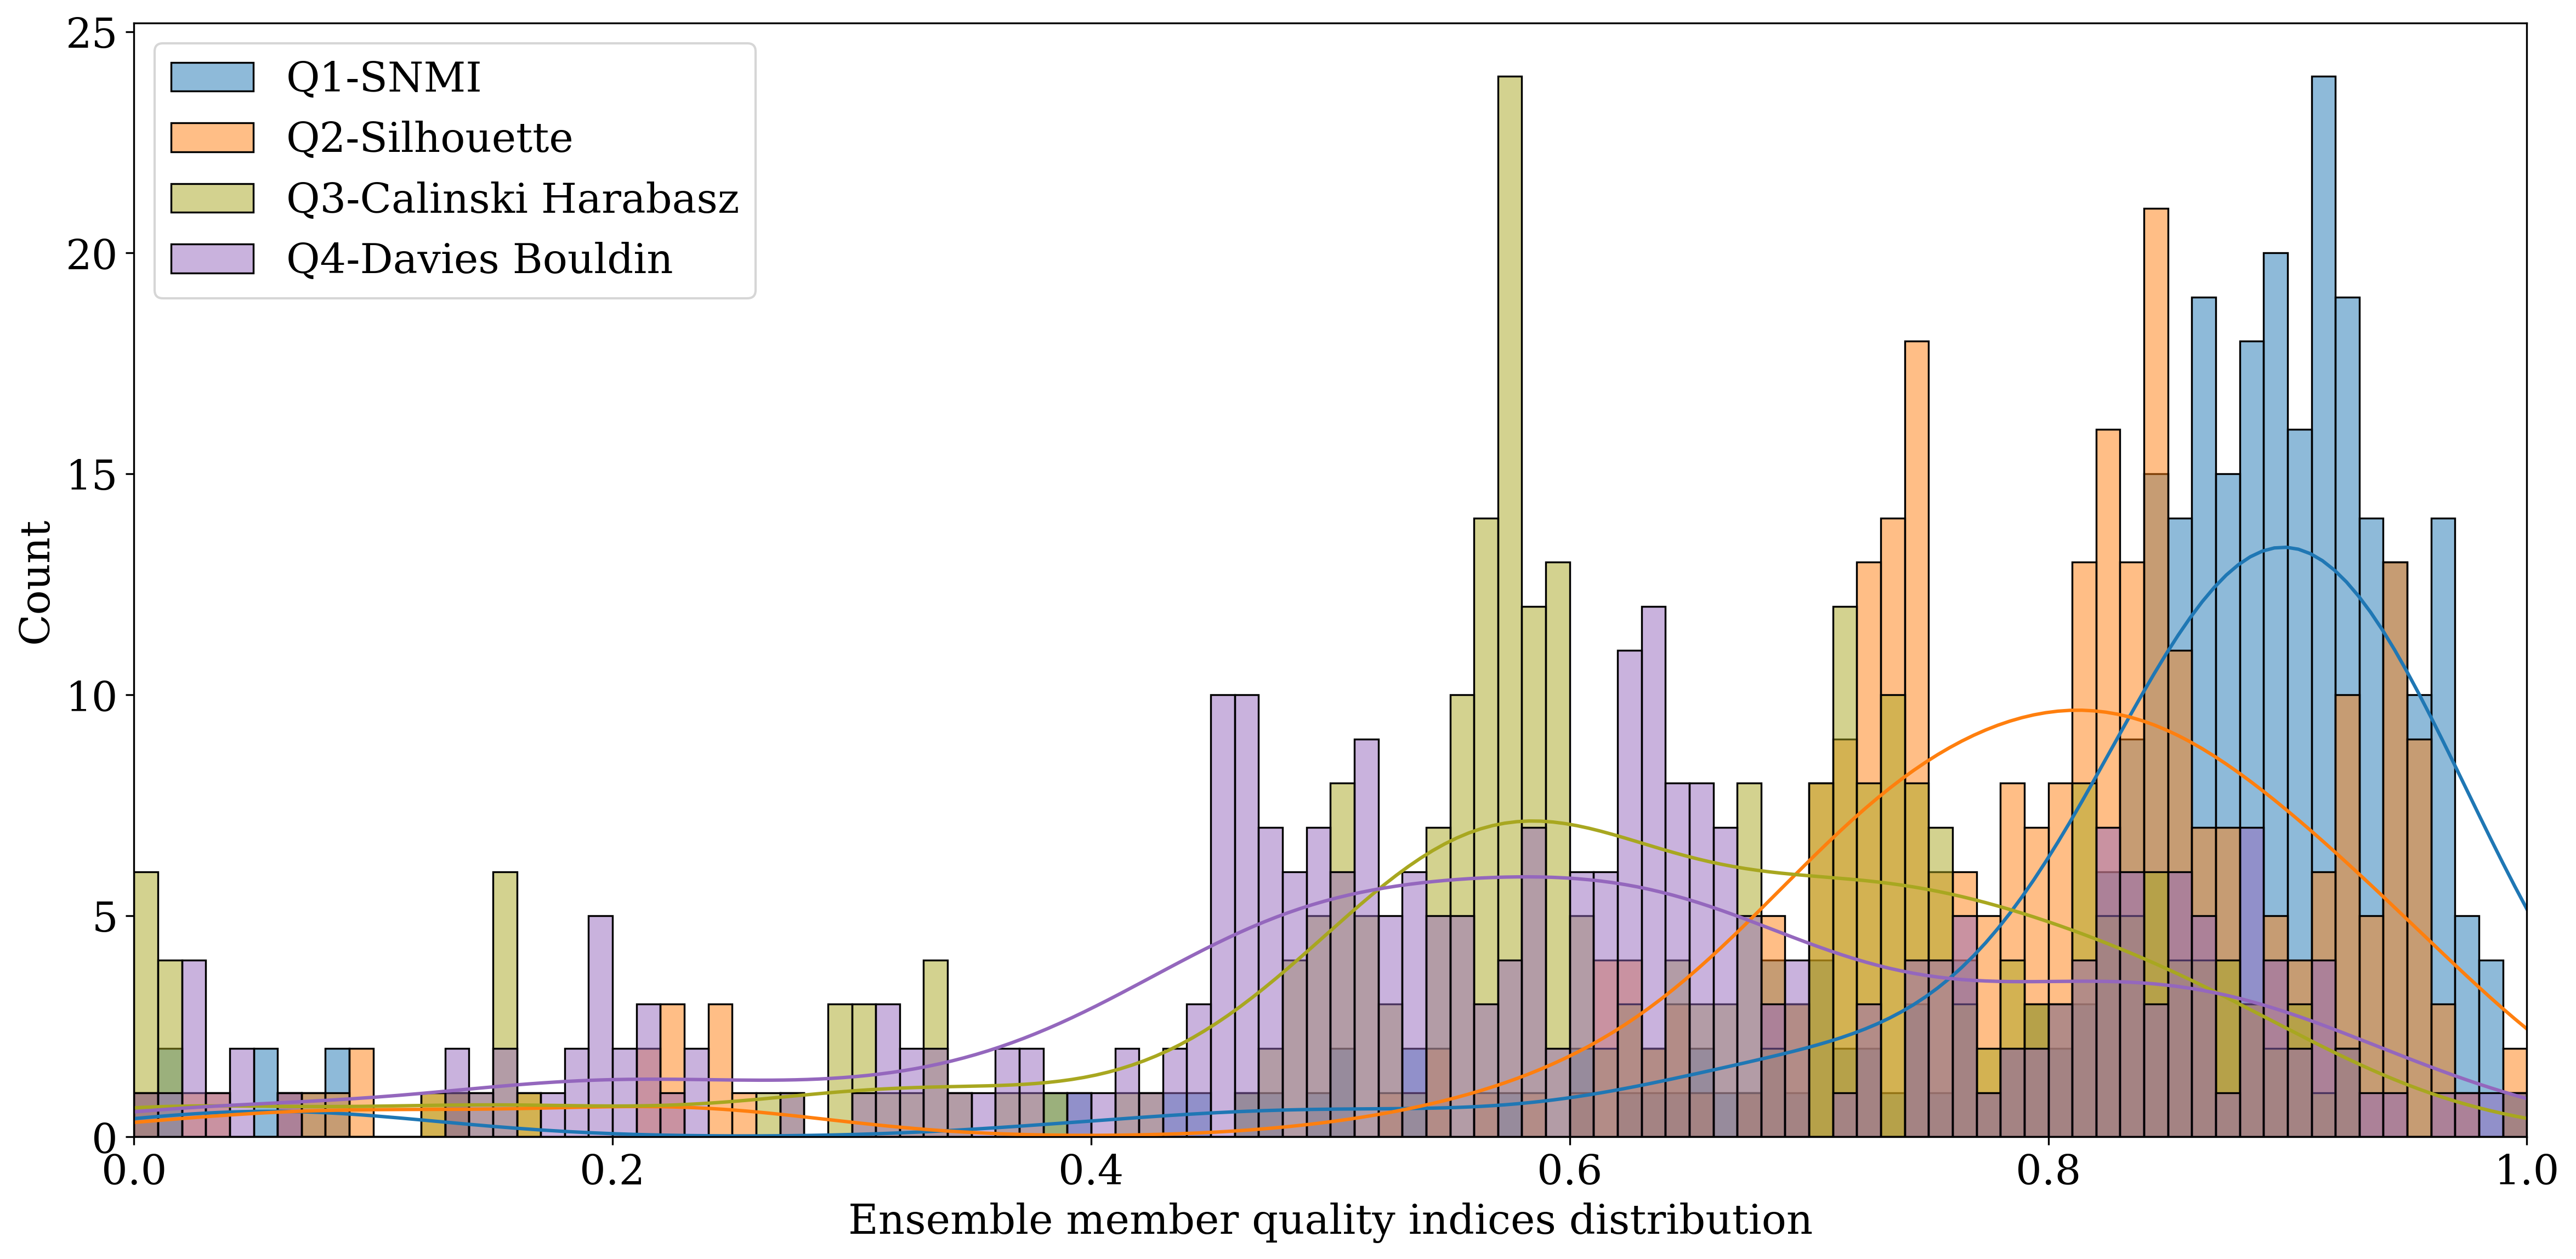

In [10]:
fig = plt.figure(figsize=(16,8), dpi = 300)
plt.rc('font', family='serif', size = 18)
sns.histplot(X_scaled[:,3], label = "Q1-SNMI" , color="#1f77b4", kde=True,bins=100)
sns.histplot(X_scaled[:,0], label = "Q2-Silhouette" , color="#ff7f0e", kde=True,bins=100)
sns.histplot(X_scaled[:,1], label = "Q3-Calinski Harabasz" , color="#a8a720", kde=True,bins=100)
sns.histplot(X_scaled[:,2], label = "Q4-Davies Bouldin" , color="#9467bd", kde=True,bins=100)
plt.xlim(0.0,1.0)
plt.xlabel('Ensemble member quality indices distribution')
legend = plt.legend(loc='upper left', shadow=False, fontsize=18)
fig.tight_layout()
plt.show()
fig.savefig(output_path+filename+" Distribution of cluster ensemble members all quality indices.png", bbox_inches="tight", dpi = 300)